(500,) (500,)


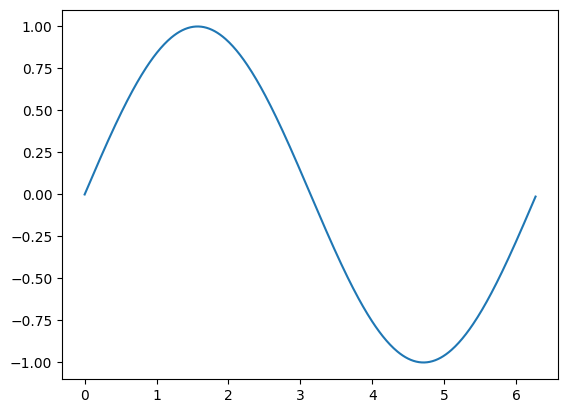

x.shape =  (500, 1)
y.shape =  (500, 1)


In [5]:
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt

# print(math.pi)
x_input = jnp.arange(0, stop=2*math.pi, step= 2*math.pi / (500))
y_target = jnp.sin(x_input)

print(x_input.shape, y_target.shape)
plt.plot(x_input,y_target)
plt.show()

x_input = x_input.reshape((-1,1))
y_target = y_target.reshape((-1,1))

print('x.shape = ', x_input.shape)
print('y.shape = ', y_target.shape)

### Example of RNG in JAX

```python
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

size = 3000

key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)
```

### Example of Linear Layer in Numpy

```python
import numpy as np

x = np.random.rand(100,1)
A = np.random.rand(1, 10)
out = np.random.rand(10, 1)
```

In [17]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jaxlib.xla_extension import ArrayImpl
import math
from jax.scipy.special import logsumexp


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(input_sizes, output_sizes, key):
  assert len(input_sizes) == len(output_sizes), 'input_sizes != output_sizes'
  keys = random.split(key, len(input_sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(input_sizes, output_sizes, keys)]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')


num_hidden = 10
input_sizes = [1, num_hidden]
output_sizes = [num_hidden, 1]
step_size = 0.01
num_epochs = 1
n_targets = 1
params = init_network_params(input_sizes, output_sizes, random.PRNGKey(0))
display_params(params, 'network_params')

network_params total num_layers =  2
(1) network_params_weights.shape = (1, 10), network_params_bias.shape = (10,)
(2) network_params_weights.shape = (10, 1), network_params_bias.shape = (1,)


In [23]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, x_input):
    activations = x_input 
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.tanh(logits)

@jit
def loss_func(params, x_input, targets):
  preds = predict(params, x_input)
  return mse(preds, targets)

### TODO:
- Investigate if these weights are actually computing the right gradients. Such that it computes $\partial f(x; \omega_{ij}) / \partial \omega_{ij}$ where $\omega_{ij}$ is the weights.
- Create a focused notebook on this part.

In [24]:
loss = loss_func(params, x_input, y_target)
grads = grad(loss_func)(params, x_input, y_target)

display_params(grads, 'grads_params')



grads_params total num_layers =  2
(1) grads_params_weights.shape = (1, 10), grads_params_bias.shape = (10,)
(2) grads_params_weights.shape = (10, 1), grads_params_bias.shape = (1,)


In [ ]:
W1.